In [1]:
import utils
import emission
import transition
import viterbi

In [2]:
entity_f_list = []
sentiment_f_list = []
vocab_size = []
new_vocab = []
k_list = []

In [3]:
LOWER = True
NORM_TENSE = True
REP_NUM = True
REP_YEAR = True
REP_SYM = True

In [4]:
dataset_folder = "data/EN/"

In [5]:
def run_k(k):
    print(">> Test k =", k)
    train_data = dataset_folder + "train"
    lines = utils.read_file_to_lines(train_data)
    
    emission_data = emission.generate_emission_table(lines,
                                                     lower=LOWER,
                                                     norm_tense=NORM_TENSE,
                                                     replace_number=REP_NUM,
                                                     replace_year=REP_YEAR,
                                                     replace_symbol=REP_SYM)
    
    hashmap = emission_data["x_hashmap"]
    word_freq = emission_data["x_word_freq"]
    smoothed_hashmap = utils.add_unk(hashmap, word_freq, k=k)
    emission_data["x_hashmap"] = smoothed_hashmap

    x_vocab = utils.get_emission_vocab(smoothed_hashmap)
    vocab_size.append(len(x_vocab))
    
    transition_pairs = transition.generate_transition_pairs(lines)
    
    y_pairs = transition_pairs["Y_pairs"]
    y_vocab = transition_pairs["y_vocab"]
    y_freq = transition_pairs["y_freq"]
    
    transition_data = transition.generate_transition_data(y_pairs, y_vocab)
    
    hmm = viterbi.HMM()
    hmm.fit_word_tokenizer(x_vocab)
    hmm.fit_pos_tokenizer(y_vocab)
    hmm.build_transition_weights(y_freq, transition_data)
    hmm.build_emission_weights(emission_data)
    
    train_data = dataset_folder + "dev.in"
    lines = utils.read_file_to_lines(train_data)

    sentences = []

    while len(lines) > 1:
        sentence_break = lines.index("")
        sentence_xy = lines[:sentence_break]
        words = [utils.preprocess_text(token,
                                       lower=LOWER,
                                       norm_tense=NORM_TENSE,
                                       replace_number=REP_NUM,
                                       replace_year=REP_YEAR,
                                       replace_symbol=REP_SYM)
                 for token in sentence_xy]
        sentence = " ".join(words).strip()
        sentences.append(sentence)
        lines = lines[sentence_break+1:]
        
    new_words = []
    for line in sentences:
        for word in line.split(" "):
            if word not in x_vocab:
                new_words.append(word)

    new_words = list(set(new_words))
    new_words.sort()
    new_vocab.append(len(new_words))
    
    # only for the progress bar!
    try:
        from tqdm import tqdm
        USE_TQDM = True
    except Exception as e:
        print(e, "TQDM import error, disable progress bar")

    if USE_TQDM:
        sentences_it = tqdm(sentences)
    else:
        sentences_it = sentences
        
    preds = []

    for line in sentences_it:
        pred = hmm.viterbi_predict(line)
        pred = hmm.pos_tokens_to_labels(pred)
        preds.append(pred)

    assert len(sentences) == len(preds)
    
    outfile = dataset_folder + "dev.p5.out"

    with open(outfile, "w") as f:
        for sentence, pred in zip(sentences, preds):
            word_array = sentence.split(" ")
            try:
                assert len(word_array) == len(pred)
                for i, word in enumerate(word_array):
                    f.write(word + " " + pred[i] +"\n")
            except:
                print(word_array)
                print(pred)
                break
            f.write("\n")
    
    gold_data = "./data/EN/dev.out"
    pred_data = "./data/EN/dev.p5.out"

    data = utils.run_eval(gold_data, pred_data)
    
    entity_f_list.append(data["entity_f"])
    sentiment_f_list.append(data["sentiment_f"])
    k_list.append(k)

    print("Results")
    print("Entity F:", data["entity_f"])
    print("Sentiment F:", data["sentiment_f"])

In [6]:
for i in range(1, 7):
    run_k(i)

>> Test k = 1


100%|██████████| 1094/1094 [00:23<00:00, 46.64it/s]


Results
Entity F: 0.8226
Sentiment F: 0.7873
>> Test k = 2


100%|██████████| 1094/1094 [00:22<00:00, 48.15it/s]


Results
Entity F: 0.8482
Sentiment F: 0.8191
>> Test k = 3


100%|██████████| 1094/1094 [00:22<00:00, 49.20it/s]


Results
Entity F: 0.8469
Sentiment F: 0.8171
>> Test k = 4


100%|██████████| 1094/1094 [00:23<00:00, 46.11it/s]


Results
Entity F: 0.8443
Sentiment F: 0.8143
>> Test k = 5


100%|██████████| 1094/1094 [00:23<00:00, 46.16it/s]


Results
Entity F: 0.8437
Sentiment F: 0.8138
>> Test k = 6


100%|██████████| 1094/1094 [00:22<00:00, 49.24it/s]


Results
Entity F: 0.8402
Sentiment F: 0.8099


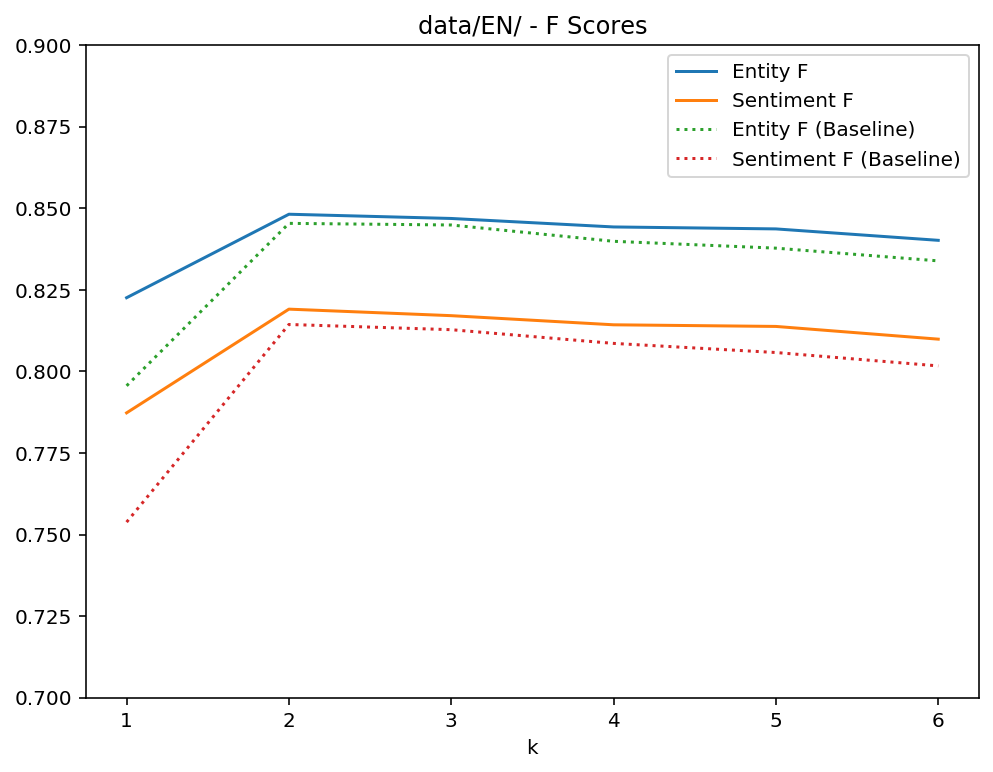

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

baseline_entity = [0.7956, 0.8454, 0.8449, 0.8399, 0.8378, 0.8339]
baseline_sentiment = [0.7538, 0.8144, 0.8128, 0.8086, 0.8058, 0.8017]

plt.figure(figsize=(8,6))
plt.plot(k_list, entity_f_list, label="Entity F")
plt.plot(k_list, sentiment_f_list, label="Sentiment F")
plt.plot(k_list, baseline_entity, label="Entity F (Baseline)", linestyle="dotted")
plt.plot(k_list, baseline_sentiment, label="Sentiment F (Baseline)", linestyle="dotted")
plt.xlabel("k")
plt.ylim(0.7, 0.9)
plt.title(dataset_folder + " - F Scores")
plt.legend()
plt.show()

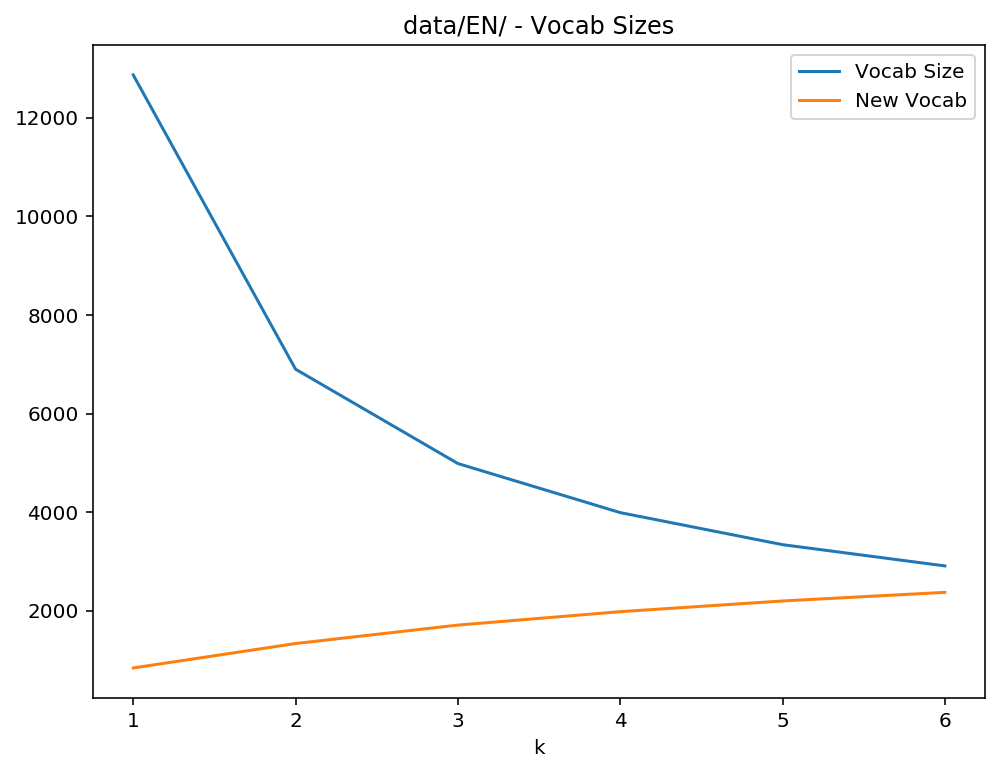

In [8]:
plt.figure(figsize=(8,6))
plt.plot(k_list, vocab_size, label="Vocab Size")
plt.plot(k_list, new_vocab, label="New Vocab")
plt.xlabel("k")
plt.title(dataset_folder + " - Vocab Sizes")
plt.legend()
plt.show()